In [32]:
!pip install saliency

In [33]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import saliency.core as saliency
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import decode_predictions

%matplotlib inline

In [34]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im)
  plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
  plt.title(title)

def ShowDivergingImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.inferno, vmin=0, vmax=1)
  plt.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im, cmap='inferno')
  plt.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((299,299))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.inception_v3.preprocess_input(im)
  return im

In [35]:
model = tf.keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=(299, 299, 3),
                    pooling=None, classes=1000, classifier_activation='softmax')

In [36]:
# m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
# conv_layer = m.get_layer('block5_conv3')
# model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])
# model.summary()

In [37]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [38]:
drive.mount("data")

Drive already mounted at data; to attempt to forcibly remount, call drive.mount("data", force_remount=True).


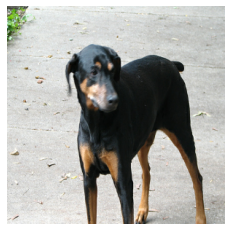

In [39]:
# Load the image
im_orig = LoadImage('data/My Drive/Colab Notebooks/doberman.png')
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

# im = im[:,:,:3]

In [40]:
predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

out = model.predict(np.array([im]))
print(decode_predictions(out, top=3))

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236

[[('n02107142', 'Doberman', 0.9463265), ('n02107312', 'miniature_pinscher', 0.0074170846), ('n02087046', 'toy_terrier', 0.0029748091)]]
Prediction class: 236


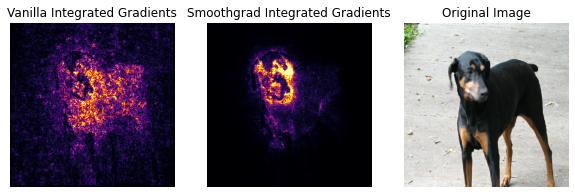

In [41]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 10
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowDivergingImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=plt.subplot(ROWS, COLS, 1))
ShowDivergingImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=plt.subplot(ROWS, COLS, 2))
ax=plt.subplot(ROWS, COLS, 3)
plt.axis('off')
plt.title('Original Image')
plt.imshow(im_orig)